In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import matplotlib.dates as mdates
from datetime import timedelta
from datetime import datetime
import copy

from xgboost import XGBRegressor 

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', 200)
pd.set_option("display.max_rows",100)

In [2]:
df = pd.read_csv("data/processed/multi_cell_training_base.csv").drop(columns=[
              'ESMode3_0', 'ESMode4_0', 'ESMode5_0', 'Mode_0', 
              'ESMode3_1', 'ESMode4_1', 'ESMode5_1', 'Mode_1', 
              'ESMode3_2', 'ESMode4_2', 'ESMode5_2', 'Mode_2', 
              'ESMode3_3', 'ESMode4_3', 'ESMode5_3', 'Mode_3',
              "is pred",
             ]) # Drop the columns that has low correlation with energy

lag_cols = [col for col in df.columns if "lag" in col]

# StandardScaler for column scaling
scaled_column_names = ["load",	"ESMode1",	"ESMode2",	"ESMode6",	"Frequency", "Bandwidth",	"TXpower"]
scaled_columns = []
for i in range(4): scaled_columns += list(pd.Series(scaled_column_names)+ f"_{i}")
scaled_columns += (lag_cols + ["Antennas", "Avg", "Num Working Cell"])
sscaler1 = StandardScaler()
sscaler2 = StandardScaler()

df.head(3)

,Time,BS,load_0,load_0_lag_1h,load_0_lag_2h,load_0_lag_3h,ESMode1_0,ESMode1_0_lag_1h,ESMode1_0_lag_2h,ESMode1_0_lag_3h,ESMode2_0,ESMode2_0_lag_1h,ESMode2_0_lag_2h,ESMode2_0_lag_3h,ESMode6_0,ESMode6_0_lag_1h,ESMode6_0_lag_2h,ESMode6_0_lag_3h,Frequency_0,Bandwidth_0,TXpower_0,Type10_0,Type11_0,Type12_0,Type2_0,Type3_0,Type4_0,Type5_0,Type6_0,Type7_0,Type8_0,Type9_0,load_1,load_1_lag_1h,load_1_lag_2h,load_1_lag_3h,ESMode1_1,ESMode1_1_lag_1h,ESMode1_1_lag_2h,ESMode1_1_lag_3h,ESMode2_1,ESMode2_1_lag_1h,ESMode2_1_lag_2h,ESMode2_1_lag_3h,ESMode6_1,ESMode6_1_lag_1h,ESMode6_1_lag_2h,ESMode6_1_lag_3h,Frequency_1,Bandwidth_1,TXpower_1,Type10_1,Type11_1,Type12_1,Type2_1,Type3_1,Type4_1,Type5_1,Type6_1,Type7_1,Type8_1,Type9_1,load_2,load_2_lag_1h,load_2_lag_2h,load_2_lag_3h,ESMode1_2,ESMode1_2_lag_1h,ESMode1_2_lag_2h,ESMode1_2_lag_3h,ESMode2_2,ESMode2_2_lag_1h,ESMode2_2_lag_2h,ESMode2_2_lag_3h,ESMode6_2,ESMode6_2_lag_1h,ESMode6_2_lag_2h,ESMode6_2_lag_3h,Frequency_2,Bandwidth_2,TXpower_2,Type10_2,Type11_2,Type12_2,Type2_2,Type3_2,Type4_2,Type5_2,Type6_2,Type7_2,Type8_2,Type9_2,load_3,load_3_lag_1h,load_3_lag_2h,load_3_lag_3h,ESMode1_3,ESMode1_3_lag_1h,ESMode1_3_lag_2h,ESMode1_3_lag_3h,ESMode2_3,ESMode2_3_lag_1h,ESMode2_3_lag_2h,ESMode2_3_lag_3h,ESMode6_3,ESMode6_3_lag_1h,ESMode6_3_lag_2h,ESMode6_3_lag_3h,Frequency_3,Bandwidth_3,TXpower_3,Type10_3,Type11_3,Type12_3,Type2_3,Type3_3,Type4_3,Type5_3,Type6_3,Type7_3,Type8_3,Type9_3,Num Working Cell,Hour Sin,Hour Cos,Day Sin,Day Cos,Antennas,Energy,Energy_lag_1h,Energy_lag_2h,Energy_lag_1D,Avg
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,20,6.875934,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.258819,0.965926,-0.781831,0.62349,4,64.275037,NaN,NaN,NaN,0.000000
1,2023-01-01 02:00:00,B_0,0.344468,0.487936,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,365.0,20,6.875934,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.500000,0.866025,-0.781831,0.62349,4,55.904335,64.275037,NaN,NaN,64.275037
2,2023-01-01 03:00:00,B_0,0.193766,0.344468,0.487936,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,365.0,20,6.875934,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.707107,0.707107,-0.781831,0.62349,4,57.698057,55.904335,64.275037,NaN,60.089686


In [3]:
n_dynamic = 4*4 # Number of dynamic features in cell-level (Load, ESMode1, ESMode2, ESMode 6 and lag features)
n_static = 14 # Number of static features in cell-level (Bandwidth, Frequency, TXPower, One-hot encoded RUType)
n_common_with_temporal = 7+3 # (Average, Hour Sin, Hour Cos, Num Working Cell, Antennas, and lag features)
n_common_no_temporal = 2   # (Num Working Cell, Antennas, and lag features)

## Create and Train Neural Network Model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Training function. Either continues the training of a given model, or creates and trains it.
def train_nn_model(module, train_dataloader : DataLoader, X_test, y_test, n_bslevel_var, prob=0.5, epochs = 100,lr=1e-4,wd=1e-3,interval=100):
    if isinstance(module,nn.Module):
        model = module
        print("Continue the training of the given module...")
    else:
        if module is NN:
            model = module(n_bslevel_var = n_bslevel_var, p=prob)
        print("New module instance is created ({module}), starting the training...")
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    
    model.to(device)
    model.train()
    for epoch in range(1,epochs+1):
        total_loss = 0
        n_iter = 0
        for X_batch, y_batch in train_dataloader:
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred,y_batch.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()
            
            total_loss += loss.item()
            n_iter += 1

        if (interval!=0) and (epoch%interval==1 or epoch==epochs):
            print("Test:")
            model.eval()
            with torch.no_grad():
                y_test_pred = model(X_test.to(device))
                loss_test = criterion(y_test_pred,y_test.to(device))
            print(f"Epoch: {epoch} | Train MSE Loss: {total_loss/n_iter:.4f} | Test MSE Loss: {loss_test.item():.4f}")
            model.train()
    
    return model

Pytorch neural network model. The model comprised of 4 blocks. 
In the cell-level section we have three blocks: 
-  f_dynamic, f_static, f_comb1     \
In the output section we have one block:
- f_comb2  :

In [6]:
class NN(nn.Module):
    def __init__(self, n_bslevel_var, out_sz=1, p=0.2):
        super().__init__()

        self.num_bslevel_var = n_bslevel_var
        self.num_dynamic_var = n_dynamic
        self.num_static_var = n_static
        self.total_celllevel_var =  self.num_dynamic_var +  self.num_static_var
        
        dynamic_arch    = [self.num_dynamic_var, 80, 80, 3] 
        static_arch     = [self.num_static_var, 30,30, 1] 
        cell_level_arch = [dynamic_arch[-1]+static_arch[-1], 100, 100, 1] 
        comb_arch       = [cell_level_arch[-1]+n_bslevel_var, 120, 120, out_sz] 
        
        # Network for dynamic parts of the data 
        # G_dy = g(Load,Day,ESModes)
        self.gdy = nn.Sequential(
            nn.Linear(dynamic_arch[0],dynamic_arch[1]),
            nn.ReLU(),
            nn.Linear(dynamic_arch[1],dynamic_arch[2]),
            nn.ReLU(),
            nn.Linear(dynamic_arch[2],dynamic_arch[3]),
        )
        
        # Network for static parts of the data 
        # G_st = g(Frq,BW,TXp,RU)
        self.gst = nn.Sequential(
            nn.Linear(static_arch[0],static_arch[1]),
            nn.ReLU(),
            nn.Linear(static_arch[1],static_arch[2]),
            nn.ReLU(),
            nn.Linear(static_arch[2],static_arch[3]),
        )
        
        # Predict cell level energy
        self.cell_level = nn.Sequential(
            nn.Linear(cell_level_arch[0],cell_level_arch[1]),
            nn.ReLU(),
            nn.Linear(cell_level_arch[1],cell_level_arch[2]),
            nn.ReLU(),
            nn.Linear(cell_level_arch[2],cell_level_arch[3]),
        )

        # Combine temporal inputs (hour and average energy) and aggregated cell level energy prediction
        self.combinator_network = nn.Sequential(
            nn.Linear(comb_arch[0],comb_arch[1]),
            nn.ReLU(),
            nn.BatchNorm1d(comb_arch[1]),
            nn.Linear(comb_arch[1],comb_arch[2]),
            nn.ReLU(),
            nn.BatchNorm1d(comb_arch[2]),
            nn.Linear(comb_arch[2],comb_arch[3]),
        )

    def forward(self, X):
        x1 = X[:,-self.num_bslevel_var:].reshape(-1,self.num_bslevel_var) # get common parts
        X = X[:,:-self.num_bslevel_var] # get cell level parts
        
        cell_agg = torch.zeros(X.shape[0],1)
        num_cells = 4 - X.isnan().sum(1,keepdim=True)//self.total_celllevel_var
        for working_cell_num in [1,2,4]:
            idx = (num_cells==working_cell_num).squeeze(1)
            for i in range(working_cell_num):
                x = X[idx,i*self.total_celllevel_var:(i+1)*self.total_celllevel_var]
                x2 = self.gdy(x[:,:self.num_dynamic_var])
                x3 = self.gst(x[:,self.num_dynamic_var:])
                x = torch.cat((x2,x3),axis=1)
                cell_level_energy = self.cell_level(x)
                cell_agg[idx] += cell_level_energy
        
        x = torch.cat((x1,cell_agg),axis=1)
        out = self.combinator_network(x)
        return out

### Model with temporal features also used

Using running average energy value and the hour information for the base station with prior information increases the accuracy. However, if the BS we are trying to 
predict the energy value have no prior energy data, then we need to use another model.

In [7]:
def prepare_dataset_for_nn(df,sscaler, train=False):
    if train:
        df[scaled_columns] = sscaler.fit_transform(X=df[scaled_columns],y=None)
    else:
        df[scaled_columns] = sscaler.transform(X=df[scaled_columns])
    df[lag_cols] = df[lag_cols].fillna(0)

    for i in range(1,4):
        cols = []
        for j in range(1,4):
            cols.append(f"load_{i}_lag_{j}h")
            for k in [1,2,6]:
                cols.append(f"ESMode{k}_{i}_lag_{j}h")
        
        idx = df[df[f"load_{i}"].isna()].index
        df.loc[idx,cols] = np.nan
    return df

In [8]:
# Apply train-test split to the dataset
df2 = df.copy()

hidden_bs_names = ["B_0", "B_345", "B_546"] 
hidden_test_data = df2[df2["BS"].isin(hidden_bs_names)]
df2.drop(hidden_test_data.index,inplace=True)

df_train,df_test = train_test_split(df2, test_size=0.08,random_state=42)
df_test = pd.concat((df_test,hidden_test_data),axis=0)

df_train = prepare_dataset_for_nn(df_train,sscaler1,train=True)
df_test = prepare_dataset_for_nn(df_test,sscaler1,train=False)

X_train = torch.Tensor(df_train.drop(columns=["Time","BS","Energy"]).to_numpy())
y_train = torch.Tensor(df_train["Energy"].to_numpy().reshape(-1,1))
X_test = torch.Tensor(df_test.drop(columns=["Time","BS","Energy"]).to_numpy())
y_test = torch.Tensor(df_test["Energy"].to_numpy().reshape(-1,1))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Convert dataset into DataLoader with batches
train_dataloader = DataLoader(dataset=list(zip(X_train,y_train)), batch_size=1024,shuffle=False,drop_last=True)

torch.Size([84915, 130]) torch.Size([7714, 130])
torch.Size([84915, 1]) torch.Size([7714, 1])


In [9]:
torch.manual_seed(101)
model_with_temporal = train_nn_model(NN,train_dataloader, X_test, y_test, n_bslevel_var=n_common_with_temporal, epochs=250,lr=1e-3,wd=1e-2,interval=50)

New module instance is created ({module}), starting the training...
Test:
Epoch: 1 | Train MSE Loss: 820.3699 | Test MSE Loss: 802.0151
Test:
Epoch: 51 | Train MSE Loss: 4.5024 | Test MSE Loss: 5.2301
Test:
Epoch: 101 | Train MSE Loss: 4.2200 | Test MSE Loss: 5.1651
Test:
Epoch: 151 | Train MSE Loss: 4.0782 | Test MSE Loss: 4.8088
Test:
Epoch: 201 | Train MSE Loss: 3.9897 | Test MSE Loss: 4.8545
Test:
Epoch: 250 | Train MSE Loss: 3.9210 | Test MSE Loss: 4.8453


### Model which is trained without the temporal features.
For the Base Stations with no prior information.

In [10]:
# Apply train-test split to the dataset
df3 = df.copy()
hidden_test_data = df3[df3["BS"].isin(hidden_bs_names)]
df3.drop(hidden_test_data.index,inplace=True)

df_train3,df_test3 = train_test_split(df3, test_size=0.08)
df_test3 = pd.concat((df_test3,hidden_test_data),axis=0)

df_train3 = prepare_dataset_for_nn(df_train3,sscaler2,train=True)
df_test3 = prepare_dataset_for_nn(df_test3,sscaler2,train=False)

df_train3.drop(columns=["Avg","Hour Sin","Hour Cos", "Day Sin", "Day Cos", "Energy_lag_1h", "Energy_lag_2h", "Energy_lag_1D"],inplace=True)
df_test3.drop(columns=["Avg","Hour Sin","Hour Cos", "Day Sin", "Day Cos" ,"Energy_lag_1h", "Energy_lag_2h", "Energy_lag_1D"],inplace=True)

X_train = torch.Tensor(df_train3.drop(columns=["Time","BS","Energy"]).to_numpy())
y_train = torch.Tensor(df_train3["Energy"].to_numpy().reshape(-1,1))
X_test = torch.Tensor(df_test3.drop(columns=["Time","BS","Energy"]).to_numpy())
y_test = torch.Tensor(df_test3["Energy"].to_numpy().reshape(-1,1))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# Convert dataset into DataLoader with batches
train_dataloader = DataLoader(dataset=list(zip(X_train,y_train)), batch_size=1024,shuffle=True,drop_last=True)

torch.Size([84915, 122]) torch.Size([7714, 122])
torch.Size([84915, 1]) torch.Size([7714, 1])


In [11]:
torch.manual_seed(1001001)
model_no_temporal = train_nn_model(NN,train_dataloader, X_test, y_test,n_bslevel_var=n_common_no_temporal,epochs=110,lr=1e-3,wd=1e-2,interval=50)

New module instance is created ({module}), starting the training...
Test:
Epoch: 1 | Train MSE Loss: 845.4266 | Test MSE Loss: 792.4219
Test:
Epoch: 51 | Train MSE Loss: 16.6789 | Test MSE Loss: 16.9879
Test:
Epoch: 101 | Train MSE Loss: 16.4786 | Test MSE Loss: 16.7885
Test:
Epoch: 110 | Train MSE Loss: 16.4608 | Test MSE Loss: 17.0969


#### Clustered XGBoostRegression

In [12]:
def fit_cluster_reg_model(df, model, n_clusters=4, params={},verbose=False):

    kmeans = KMeans(n_clusters=n_clusters, n_init="auto",random_state=808)
    kmeans.fit(df[cluster_columns].fillna(0))
    
    df["K Label"] = kmeans.labels_
    print(df["K Label"].value_counts())
    regs = {}
    avg_metrics = {"RMSE" : 0, "MAE" : 0, "R2" : 0, "MAPE" : 0}
    n_iter = 0
    
    for label in sorted(df["K Label"].unique()):
        df_for_label = df[df["K Label"] == label]
        
        df_train, df_test = train_test_split(df_for_label, test_size=0.1,random_state=808)
        
        X = df_train.drop(columns=["K Label", "Energy"]).to_numpy()
        y = df_train["Energy"].to_numpy()
        
        X_test = df_test.drop(columns=["K Label", "Energy"]).to_numpy()
        y_test = df_test["Energy"].to_numpy()
        
        reg = model(**params)
        reg.fit(X,y,
                eval_set = [(X,y),(X_test,y_test)],
                verbose=0,
                early_stopping_rounds=50
                )

        y_pred = reg.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))
        mae_test = mean_absolute_error(y_test,y_pred)
        r2_test = r2_score(y_test, y_pred)
        mape_test = mean_absolute_percentage_error(y_test,y_pred)
        avg_metrics["RMSE"] += rmse_test
        avg_metrics["MAE"] += mae_test
        avg_metrics["R2"] += r2_test
        avg_metrics["MAPE"] += mape_test
        
        if verbose:
            print(f"Label: {label} Test data metrics: RMSE {rmse_test:.2f} | MAE {mae_test:.2f} | R2 {r2_test:.2f} | MAPE {mape_test:.2f}")
        
        regs[label] = reg
        n_iter += 1
    
    avg_metrics["RMSE"] /= n_iter; avg_metrics["MAE"] /= n_iter; avg_metrics["R2"]  /= n_iter; avg_metrics["MAPE"] /= n_iter
    print(f'Rollout: RMSE {avg_metrics["RMSE"]:.2f} | MAE {avg_metrics["MAE"]:.2f} | R2 {avg_metrics["R2"]:.2f} | MAPE {avg_metrics["MAPE"]:.2f}')
    
    return regs,kmeans

In [13]:
# Apply train-test split to the dataset
df4 = df.copy()

cluster_column_names = ["load", "ESMode1", "ESMode2", "ESMode6", "Frequency", "Bandwidth", "TXpower"]
cluster_column_names += [f"Type{i}" for i in range(2,13)]
cluster_columns = []
for i in range(4):
    for cname in cluster_column_names:
        cluster_columns.append(f"{cname}_{i}") 
cluster_columns += ["Num Working Cell", "Antennas"]

In [14]:
def predict_clustered_model(regs,kmeans, df):
    df["Prediction"] = 0
    df["K Label"] = kmeans.predict(df[cluster_columns].fillna(0))
    for label in sorted(df["K Label"].unique()):
        df_for_label = df[df["K Label"] == label]
        X = df_for_label.drop(columns=["K Label", "Energy", "Prediction"]).to_numpy()
        df.loc[df_for_label.index, "Prediction"] = regs[label].predict(X)
    return df["Prediction"].values

In [15]:
np.random.seed(101)
params = {"n_estimators":12_000,"eta":0.1}
regs,kmeans = fit_cluster_reg_model(df4.drop(columns=["Time","BS", "Avg","Energy_lag_1h", "Energy_lag_2h", "Energy_lag_1D"]),XGBRegressor, 4, params, verbose=True)

K Label
1    30494
3    29945
2    27835
0     4355
Name: count, dtype: int64
Label: 0 Test data metrics: RMSE 4.63 | MAE 3.65 | R2 0.85 | MAPE 0.08
Label: 1 Test data metrics: RMSE 4.82 | MAE 3.75 | R2 0.90 | MAPE 0.11
Label: 2 Test data metrics: RMSE 2.88 | MAE 1.97 | R2 0.71 | MAPE 0.09
Label: 3 Test data metrics: RMSE 2.51 | MAE 1.66 | R2 0.93 | MAPE 0.08
Rollout: RMSE 3.71 | MAE 2.76 | R2 0.85 | MAPE 0.09


Calculate metrics of all models without the further training

In [16]:
def metrics(model, X, y, df_name:str, kmeans=None):
    if isinstance(model,nn.Module):
        model.to(device)
        model.eval()
        with torch.no_grad():
            y_pred = model(X).detach().numpy()
    else:
        y_pred = predict_clustered_model(model,kmeans,X)
        
    mse= mean_squared_error(y,y_pred)
    mae = mean_absolute_error(y,y_pred)
    r2 = r2_score(y, y_pred)
    mape= mean_absolute_percentage_error(y,y_pred)
    print(f"{df_name} Data Metrics: MSE {mse:.2f} | RMSE {np.sqrt(mse):.2f} | MAE {mae:.2f} | R2 {r2:.2f} | MAPE {mape:.2f}")

As you can see from the metrics below, the model performance is not very good without further training

In [20]:
print("Model with temporal: ")
metrics(model_with_temporal,torch.Tensor(df_train.drop(columns=["Time","BS","Energy"]).to_numpy()),torch.Tensor(df_train["Energy"].to_numpy().reshape(-1,1)), "Train")
metrics(model_with_temporal,torch.Tensor(df_test.drop(columns=["Time","BS","Energy"]).to_numpy()),torch.Tensor(df_test["Energy"].to_numpy().reshape(-1,1)), "Test")

print("Model without temporal: ")
metrics(model_no_temporal,torch.Tensor(df_train3.drop(columns=["Time","BS","Energy"]).to_numpy()),torch.Tensor(df_train3["Energy"].to_numpy().reshape(-1,1)), "Train")
metrics(model_no_temporal,torch.Tensor(df_test3.drop(columns=["Time","BS","Energy"]).to_numpy()),torch.Tensor(df_test3["Energy"].to_numpy().reshape(-1,1)), "Test")


print("Clustered XGBoost")
metrics(regs,df4.drop(columns=["Time","BS", "Avg","Energy_lag_1h", "Energy_lag_2h", "Energy_lag_1D"]), df4["Energy"].to_numpy().reshape(-1,1),"Train",kmeans=kmeans)

Model with temporal: 
Train Data Metrics: MSE 3.92 | RMSE 1.98 | MAE 1.33 | R2 0.98 | MAPE 0.05
Test Data Metrics: MSE 4.85 | RMSE 2.20 | MAE 1.46 | R2 0.98 | MAPE 0.05
Model without temporal: 
Train Data Metrics: MSE 16.27 | RMSE 4.03 | MAE 2.86 | R2 0.92 | MAPE 0.11
Test Data Metrics: MSE 17.10 | RMSE 4.13 | MAE 2.93 | R2 0.92 | MAPE 0.11
Clustered XGBoost
Train Data Metrics: MSE 10.75 | RMSE 3.28 | MAE 2.26 | R2 0.94 | MAPE 0.08


## Further training and filling the prediction data

In [21]:
df_fill = pd.read_csv("data/power_consumption_prediction.csv")
df_close_bs = pd.read_csv("data/processed/close_bs_data_static_and_dynamic.csv")

In [22]:
df_pred = pd.read_csv("data/processed/multi_cell_prediction_base.csv").drop(
    columns=[
              'ESMode3_0', 'ESMode4_0', 'ESMode5_0', 'Mode_0', 
              'ESMode3_1', 'ESMode4_1', 'ESMode5_1', 'Mode_1', 
              'ESMode3_2', 'ESMode4_2', 'ESMode5_2', 'Mode_2', 
              'ESMode3_3', 'ESMode4_3', 'ESMode5_3', 'Mode_3',
              "is pred",])
df_pred["Energy"] = np.nan
df_pred.head(3)

,Time,BS,load_0,load_0_lag_1h,load_0_lag_2h,load_0_lag_3h,ESMode1_0,ESMode1_0_lag_1h,ESMode1_0_lag_2h,ESMode1_0_lag_3h,ESMode2_0,ESMode2_0_lag_1h,ESMode2_0_lag_2h,ESMode2_0_lag_3h,ESMode6_0,ESMode6_0_lag_1h,ESMode6_0_lag_2h,ESMode6_0_lag_3h,Frequency_0,Bandwidth_0,TXpower_0,Type10_0,Type11_0,Type12_0,Type2_0,Type3_0,Type4_0,Type5_0,Type6_0,Type7_0,Type8_0,Type9_0,load_1,load_1_lag_1h,load_1_lag_2h,load_1_lag_3h,ESMode1_1,ESMode1_1_lag_1h,ESMode1_1_lag_2h,ESMode1_1_lag_3h,ESMode2_1,ESMode2_1_lag_1h,ESMode2_1_lag_2h,ESMode2_1_lag_3h,ESMode6_1,ESMode6_1_lag_1h,ESMode6_1_lag_2h,ESMode6_1_lag_3h,Frequency_1,Bandwidth_1,TXpower_1,Type10_1,Type11_1,Type12_1,Type2_1,Type3_1,Type4_1,Type5_1,Type6_1,Type7_1,Type8_1,Type9_1,load_2,load_2_lag_1h,load_2_lag_2h,load_2_lag_3h,ESMode1_2,ESMode1_2_lag_1h,ESMode1_2_lag_2h,ESMode1_2_lag_3h,ESMode2_2,ESMode2_2_lag_1h,ESMode2_2_lag_2h,ESMode2_2_lag_3h,ESMode6_2,ESMode6_2_lag_1h,ESMode6_2_lag_2h,ESMode6_2_lag_3h,Frequency_2,Bandwidth_2,TXpower_2,Type10_2,Type11_2,Type12_2,Type2_2,Type3_2,Type4_2,Type5_2,Type6_2,Type7_2,Type8_2,Type9_2,load_3,load_3_lag_1h,load_3_lag_2h,load_3_lag_3h,ESMode1_3,ESMode1_3_lag_1h,ESMode1_3_lag_2h,ESMode1_3_lag_3h,ESMode2_3,ESMode2_3_lag_1h,ESMode2_3_lag_2h,ESMode2_3_lag_3h,ESMode6_3,ESMode6_3_lag_1h,ESMode6_3_lag_2h,ESMode6_3_lag_3h,Frequency_3,Bandwidth_3,TXpower_3,Type10_3,Type11_3,Type12_3,Type2_3,Type3_3,Type4_3,Type5_3,Type6_3,Type7_3,Type8_3,Type9_3,Num Working Cell,Hour Sin,Hour Cos,Day Sin,Day Cos,Antennas,Energy,Energy_lag_1h,Energy_lag_2h,Energy_lag_1D,Avg
0,2023-01-01 06:00:00,B_0,0.189872,0.175436,0.222383,0.193766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.0,20,6.875934,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.000000e+00,6.123234e-17,-0.781831,0.62349,4,NaN,56.053812,55.156951,NaN,58.258595
1,2023-01-01 11:00:00,B_0,0.522096,0.624745,0.887798,0.759298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.0,20,6.875934,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.588190e-01,-9.659258e-01,-0.781831,0.62349,4,NaN,72.645740,78.176383,NaN,67.656951
2,2023-01-01 12:00:00,B_0,0.439968,0.522096,0.624745,0.887798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.0,20,6.875934,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.224647e-16,-1.000000e+00,-0.781831,0.62349,4,NaN,NaN,72.645740,NaN,67.656951


In [23]:
# For BSs with no prior information, we get the training data from the close BSs.
def get_close_bs_data(df,df_close_bs,bs_num,min_req_row_count=100, verbose=False):
    close_bs_nums = list(df_close_bs.loc[bs_num].values)
    if bs_num in close_bs_nums: close_bs_nums.remove(bs_num)
    total_row = 0
    df_close_data = pd.DataFrame(columns=df.columns)
    for close_bs in close_bs_nums:
        close_bs_name = f"B_{close_bs}"
        df_close_filt = df[df["BS"]==close_bs_name]
        df_close_filt = df_close_filt[~df_close_filt["Energy"].isna()]
        if len(df_close_filt) > 0: 
            df_close_filt = df_close_filt.sample(frac=0.8) 
            total_row += len(df_close_filt)
            df_close_data = pd.concat([df_close_data,df_close_filt],axis=0) 
            if verbose: print(f"----> Self: {bs_num} Close: {close_bs_name} | Num: {len(df_close_filt)} Total: {total_row}")
        
        if total_row >= min_req_row_count: 
            break
    return df_close_data

In [24]:
# Further training function, trains the given base model to make it more accurate on the given BS
# It is kind of similar to transfer learning.
def train_on_bs_data(model,df_filt,is_pred,epochs=20,max_loss=5.,lr=1e-3,wd=1e-2,interval=0):    
    X_data = df_filt.drop(columns="Energy").to_numpy(dtype=np.float64)
    y_data = df_filt["Energy"].to_numpy(dtype=np.float64)
    X_data = torch.Tensor(X_data)
    y_data = torch.Tensor(y_data).reshape(-1,1)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
    
    model.train()

    loss_calc = 100.
    epoch=1
    stop = False
    while not stop:
        stop = (is_pred and (epoch>epochs) ) or ((not is_pred) and (epoch>epochs) and (loss_calc < max_loss))
        y_pred = model(X_data.to(device))
        loss = criterion(y_pred,y_data.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_calc = loss.item()
        
        if interval > 0 and (epoch==1 or epoch%interval==0):
            print(f"------> epoch ({epoch}) | Loss: {loss_calc}")
        epoch+=1

### Further training loop

In [33]:
df_1  = df.copy()
df_2 = df_pred.copy()
df_1["Prediction"] = 0
df_2["Prediction"] = 0
df_1["is pred"] = False
df_2["is pred"] = True
df_data = pd.concat((df_1,df_2),axis=0).reset_index(drop=True)

bs_list = list(df_data["BS"].unique()) # To further train and predict all the dataset
# bs_list = list( set(df_data[df_data["is pred"]==True]["BS"].unique()) - set(df_data[df_data["is pred"]==False]["BS"].unique()) ) # To further train and predict the unseen dataset

all_data_cnt = df_data["BS"].isin(bs_list).sum()
cntr = 0
idx = 0
N = len(bs_list)

OVERTRAINING_PARAMETER = 2
MAX_LOSS_ALLOWED = 6.

for BS in sorted(bs_list):
    print(f"Working on BS: {BS}")
    df_filt = df_data[df_data["BS"]==BS]

    if sum(1-df_filt["Energy"].isna()) > 5: 
        model_bs = copy.deepcopy(model_with_temporal)

        # Prediction dataset
        df_filt = prepare_dataset_for_nn(df_filt,sscaler1,train=False)
        df_tr = df_filt[df_filt["is pred"]==False]
        df_tr = df_tr.drop(columns=["BS","Time","Prediction", "is pred"])
        df_filt = df_filt.drop(columns=["BS","Time","Prediction", "is pred", "Energy"])
        
        # Further train
        epochs = min(OVERTRAINING_PARAMETER*100, len(df_tr)*OVERTRAINING_PARAMETER)
        train_on_bs_data(model_bs,df_tr,is_pred=False,epochs=epochs,max_loss=MAX_LOSS_ALLOWED,interval=0)
        
        # Make predictions
        X_pred = torch.Tensor(df_filt.to_numpy())
        model_bs.eval()
        with torch.no_grad():
            y_pred = model_bs(X_pred).detach().numpy()
    
    else:
        # XGBoost predictions
        y_pred_xgb = predict_clustered_model(regs,kmeans,df_filt.drop(columns=["Time","BS", "Avg","Energy_lag_1h", "Energy_lag_2h", "Energy_lag_1D", "is pred"]))
        
        model_bs = copy.deepcopy(model_no_temporal)
        bss = int(BS.split("_")[1])
        df_tr = get_close_bs_data(df_data,df_close_bs,bss,min_req_row_count=120)
        
        df_tr = prepare_dataset_for_nn(df_tr,sscaler2,train=False)
        df_filt = prepare_dataset_for_nn(df_filt,sscaler2,train=False)
        df_tr = df_tr.drop(columns=["BS","Time","Prediction","is pred","Avg","Hour Sin","Hour Cos", "Day Sin", "Day Cos"])
        
        # Further train
        epochs = min(OVERTRAINING_PARAMETER*100, len(df_tr)*OVERTRAINING_PARAMETER)
        train_on_bs_data(model_bs,df_tr,is_pred=True,epochs=epochs,max_loss=MAX_LOSS_ALLOWED,interval=0)
        
        # Make predictions
        X_pred = torch.Tensor(df_filt.drop(columns=["BS","Time","Prediction","is pred","Energy","Avg","Hour Sin","Hour Cos"]).to_numpy())
        model_bs.eval()
        with torch.no_grad():
            y_pred_nn = model_bs(X_pred).detach().numpy().reshape(-1)
            
        y_pred = 0.7*y_pred_nn + 0.3*y_pred_xgb # Ensemble
        
         
    df_data.loc[df_filt.index,"Prediction"] = y_pred
    
    cntr += len(df_filt)
    idx += 1
    print(f"Filled: {cntr/all_data_cnt*100:.2f}% [{cntr}/{all_data_cnt}] | BS: [{idx}/{N}]")


Working on BS: B_0
Filled: 0.11% [132/118768] | BS: [1/1020]
Working on BS: B_1
Filled: 0.22% [264/118768] | BS: [2/1020]
Working on BS: B_10
Filled: 0.34% [406/118768] | BS: [3/1020]
Working on BS: B_100
Filled: 0.46% [547/118768] | BS: [4/1020]
Working on BS: B_1000
Filled: 0.48% [571/118768] | BS: [5/1020]
Working on BS: B_1001
Filled: 0.50% [595/118768] | BS: [6/1020]
Working on BS: B_1002
Filled: 0.52% [619/118768] | BS: [7/1020]
Working on BS: B_1003
Filled: 0.54% [643/118768] | BS: [8/1020]
Working on BS: B_1004
Filled: 0.56% [667/118768] | BS: [9/1020]
Working on BS: B_1005
Filled: 0.58% [691/118768] | BS: [10/1020]
Working on BS: B_1006
Filled: 0.60% [715/118768] | BS: [11/1020]
Working on BS: B_1007
Filled: 0.62% [739/118768] | BS: [12/1020]
Working on BS: B_1008
Filled: 0.64% [763/118768] | BS: [13/1020]
Working on BS: B_1009
Filled: 0.66% [787/118768] | BS: [14/1020]
Working on BS: B_101
Filled: 0.78% [928/118768] | BS: [15/1020]
Working on BS: B_1010
Filled: 0.80% [952/118

In [34]:
df_data[["Time", "BS", "Prediction", "Energy", "is pred"]].to_csv("data/predictions/all_nn_xgb.csv",index=False)

## Plots & Submit File

In [35]:
def plot_training(df,base_station='B_0'):
  df = df[df['BS'] == base_station]
  df["Time"] = pd.to_datetime(df["Time"])
  df = df.set_index("Time").sort_index()
  
  y = df[df["is pred"]==False]['Energy']
  y_p = df[df["is pred"]==False]['Prediction']
  if len(y)>0:
    mse_test = np.sqrt(mean_squared_error(y,y_p))
    mae_test = mean_absolute_error(y,y_p)
    r2_test = r2_score(y, y_p)
    mape_test = mean_absolute_percentage_error(y, y_p)
    print(f"MSE {mse_test:.2f} | RMSE {np.sqrt(mse_test):.2f} | MAE {mae_test:.2f} | R2 {r2_test:.2f} | MAPE: {mape_test:.2f}")

  plt.figure(figsize=(18,6),dpi=300)
  plt.plot(df.index,df['Energy'],marker='o',color='blue')
  plt.plot(df.index,df['Prediction'],marker='o',color='red')

  plt.xticks(np.arange(min(df.index), max(df.index),  timedelta(hours=4)),rotation=90)
  myFmt = mdates.DateFormatter('%y-%m-%d %H:%M')
  plt.gca().xaxis.set_major_formatter(myFmt)
  plt.grid(True)
  plt.title(f"Comparison of Given and Predicted Energy Values for Base Station: {base_station}")
  plt.ylabel("Energy")
  plt.legend(["Given Energy Consumption Data","Predicted Energy Consumption"])

In [36]:
def plot_predictions(energy_consumption_df,test_data,pred,df_cell,base_stations=['B_0']):
  plt.subplots(len(base_stations),1,figsize=(24,12),dpi=400)
  N = len(base_stations)
  for i,base_station in enumerate(base_stations):
    plt.subplot(100*N+11+i)
    df = pd.concat([energy_consumption_df[energy_consumption_df['BS'] == base_station],
                  test_data[test_data['BS'] == base_station]])
    df = df.set_index('Time').sort_index()
    plt.plot(df.index,df['Energy'],marker='o',color='blue')
    
    filtered_preds = pred[pred['BS'] == base_station]
    filtered_preds = filtered_preds[filtered_preds["is pred"]==True]
    plt.plot(filtered_preds.index,filtered_preds['Prediction'],color="red",marker="o",linestyle="None",markersize=8.0)
    plt.grid(True)
  
    plt.title(f"Given and Predicted Unknown Energy Values for Base Station: {base_station}")
    plt.ylabel("Energy")
    plt.xlabel("Time")
    plt.legend(["Given Energy Consumption Data","Predicted Unknown Energy Consumption Data"])

In [37]:
df_energy_cons = pd.read_csv("data/energy_consumption.csv")
df_pow_na = pd.read_csv("data/power_consumption_prediction.csv")

df_energy_cons["Time"] = pd.to_datetime(df_energy_cons["Time"])
df_pow_na["Time"] = pd.to_datetime(df_pow_na["Time"])

df_cell = pd.read_csv("data/cell_level.csv")
df_cell["Time"] = pd.to_datetime(df_cell["Time"])
df_cell = df_cell.set_index('Time').sort_index()

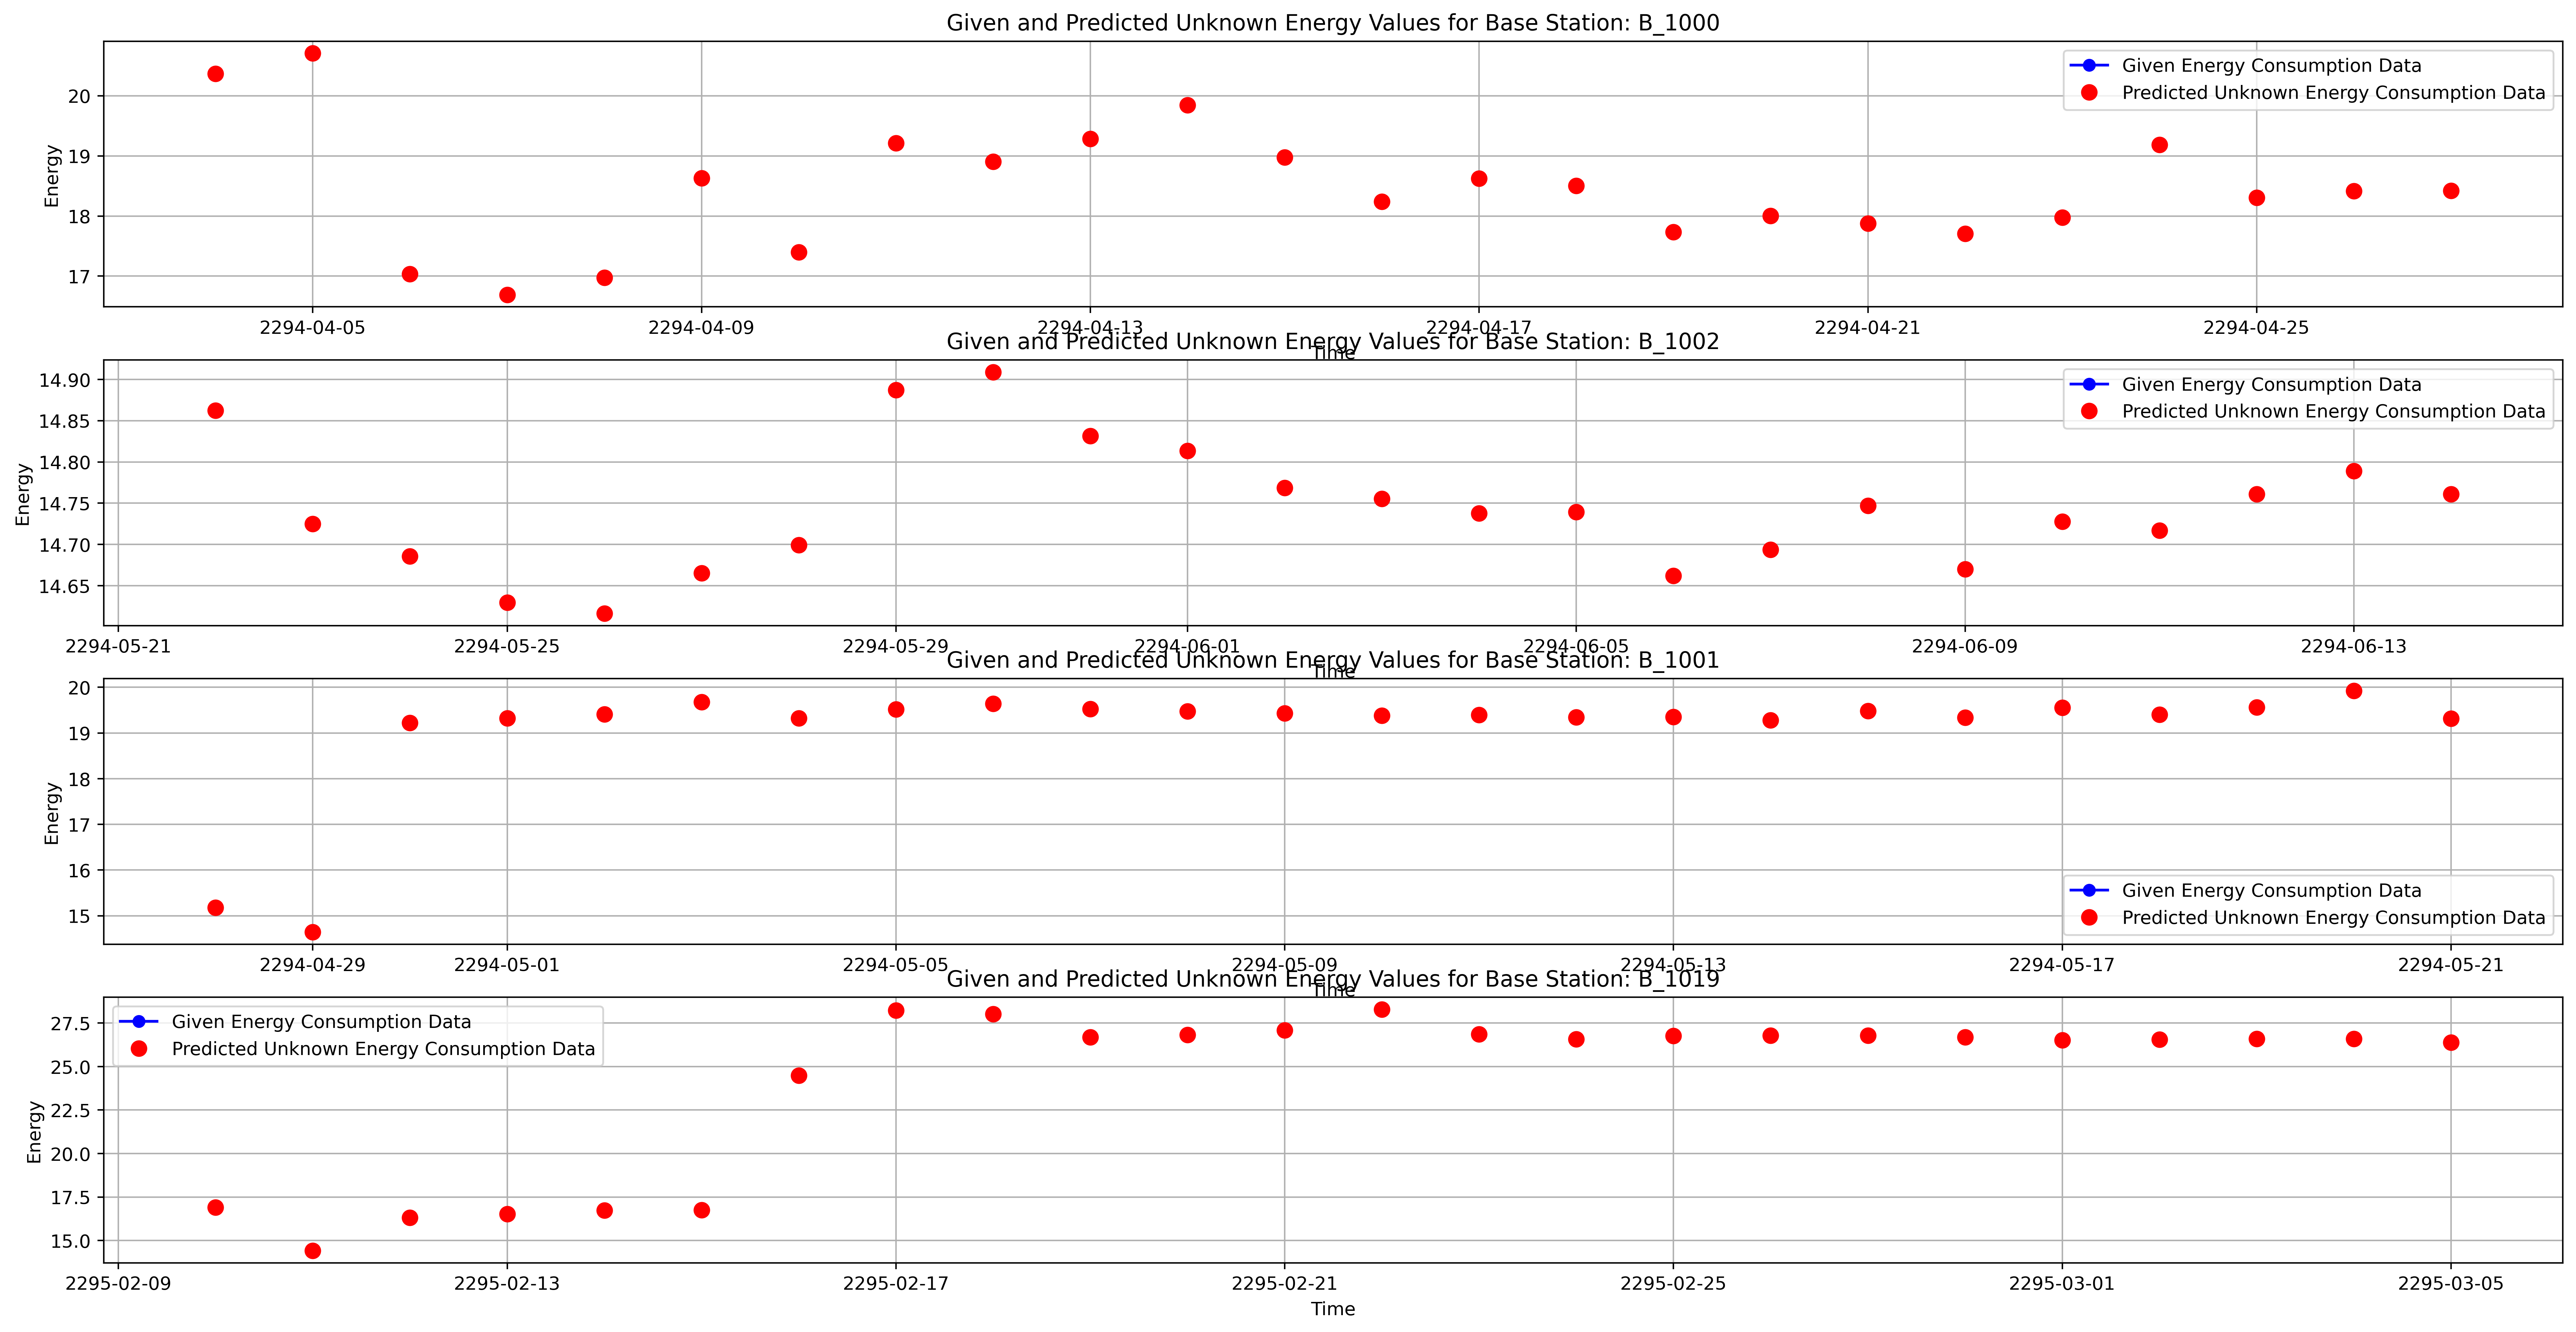

In [38]:
plot_predictions(df_energy_cons,df_pow_na,df_data,df_cell,["B_1000","B_1002","B_1001","B_1019"])

MSE 2.42 | RMSE 1.55 | MAE 2.41 | R2 0.94 | MAPE: 0.03


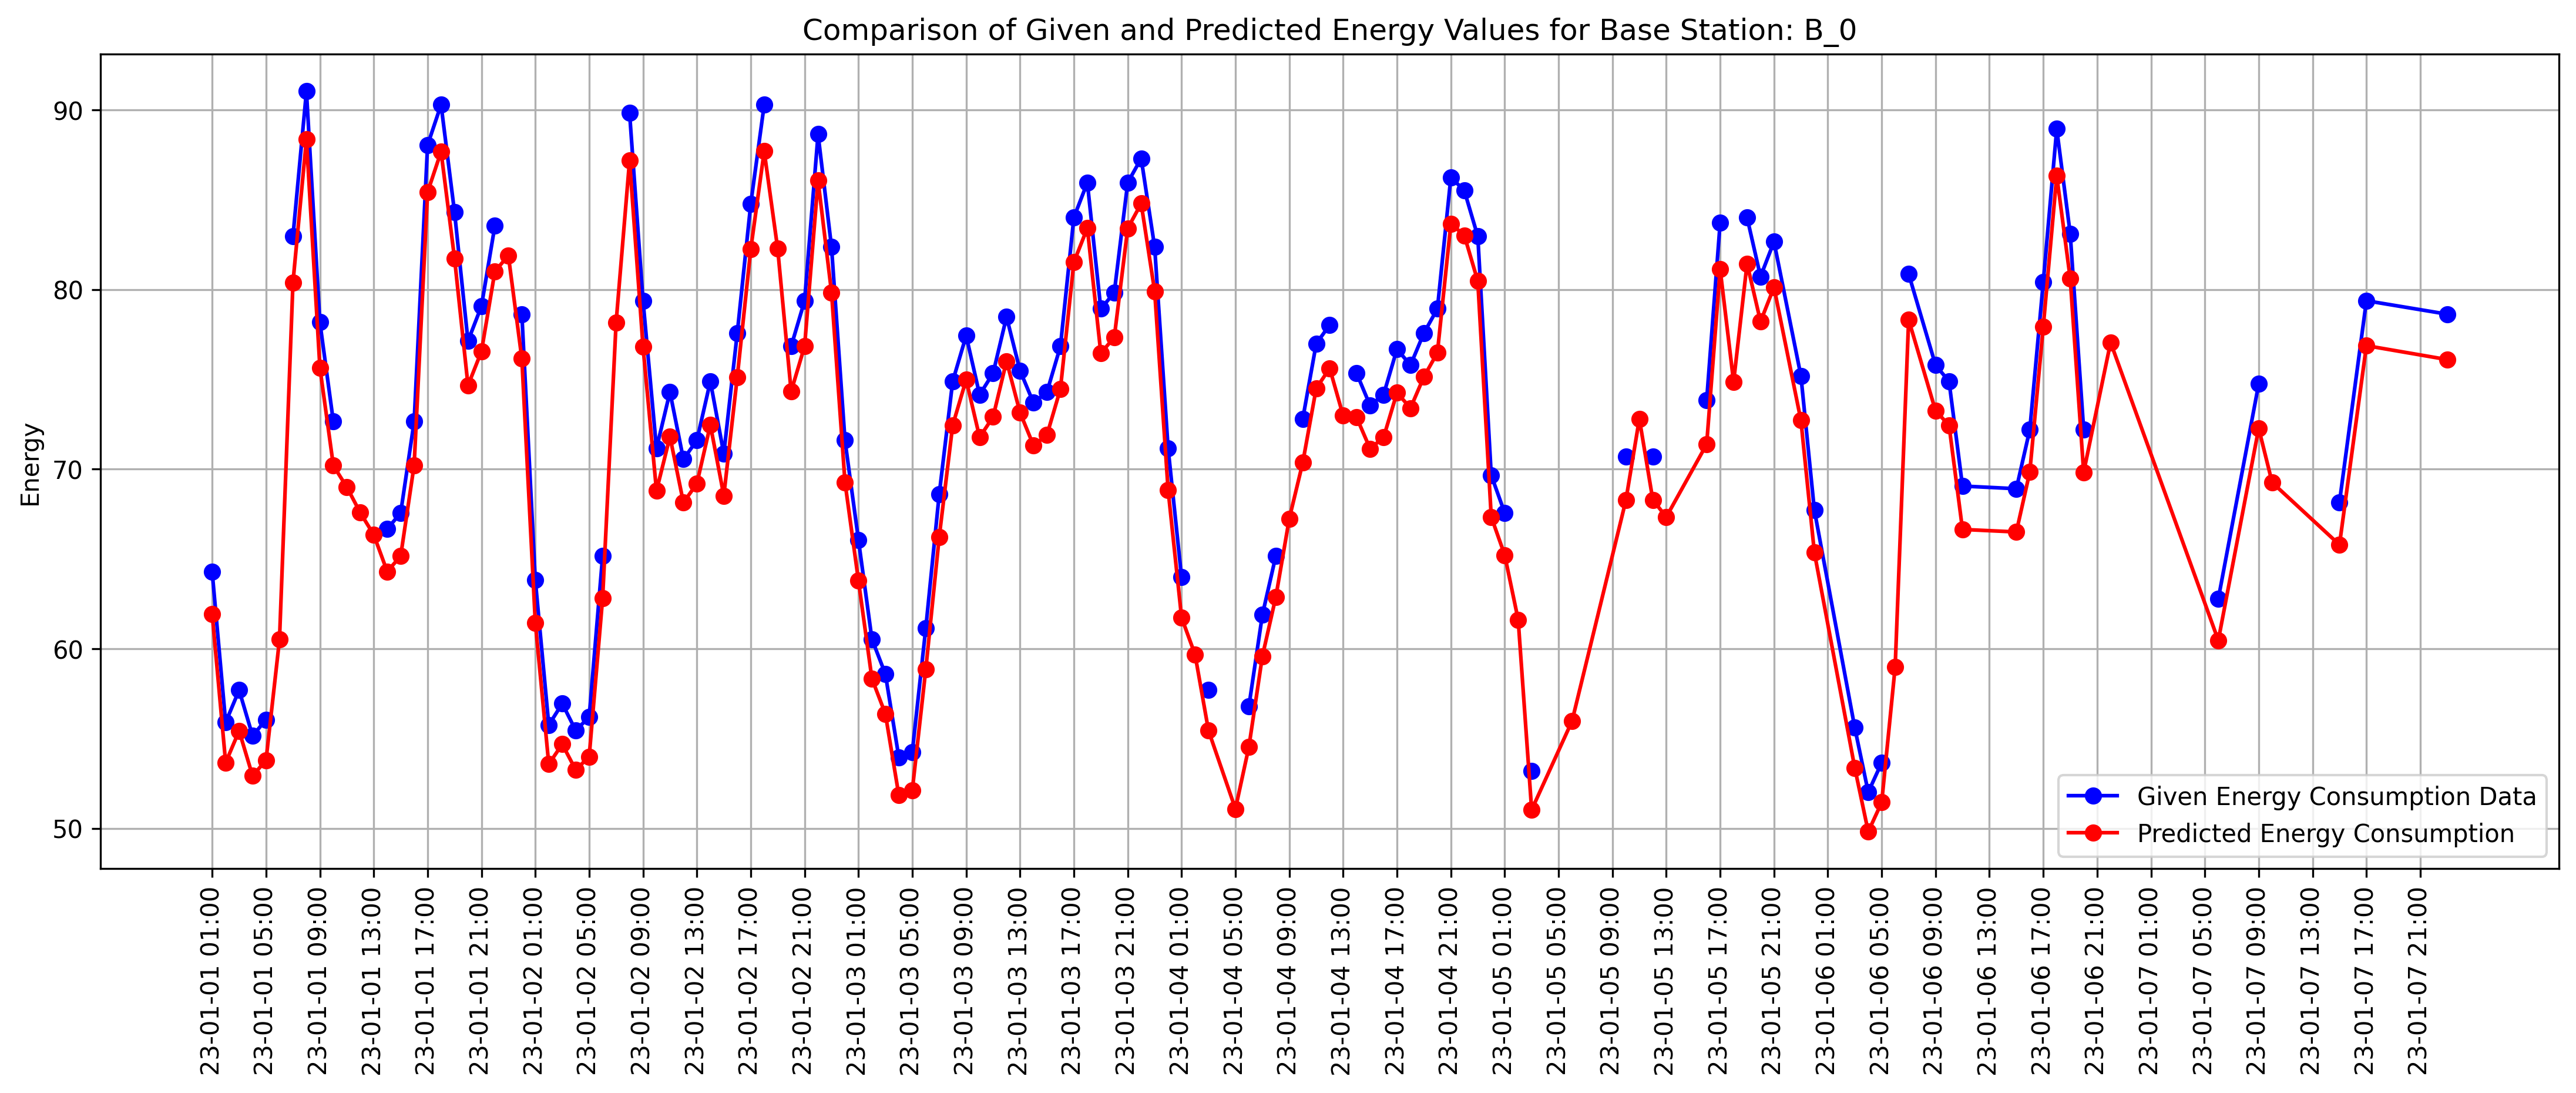

In [39]:
plot_training(df_data, "B_0")

Print the metrics after further training

In [40]:
df_metric = df_data.loc[df_train.index]
y_pred = df_metric["Prediction"]
y = df_metric["Energy"]

mse= mean_squared_error(y,y_pred)
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y, y_pred)
mape= mean_absolute_percentage_error(y,y_pred)
print(f"Train Data Metrics: MSE {mse:.2f} | RMSE {np.sqrt(mse):.2f} | MAE {mae:.2f} | R2 {r2:.2f} | MAPE {mape:.2f}")

df_metric = df_data.loc[df_test.index]
y_pred = df_metric["Prediction"]
y = df_metric["Energy"]

mse= mean_squared_error(y,y_pred)
mae = mean_absolute_error(y,y_pred)
r2 = r2_score(y, y_pred)
mape= mean_absolute_percentage_error(y,y_pred)
print(f"Test Data Metrics: MSE {mse:.2f} | RMSE {np.sqrt(mse):.2f} | MAE {mae:.2f} | R2 {r2:.2f} | MAPE {mape:.2f}")

Train Data Metrics: MSE 1.21 | RMSE 1.10 | MAE 0.64 | R2 0.99 | MAPE 0.03
Test Data Metrics: MSE 1.28 | RMSE 1.13 | MAE 0.66 | R2 0.99 | MAPE 0.03


In [41]:
df_submit = df_data[df_data["is pred"]][["Time","BS","Prediction"]]
df_submit.rename(columns={"Prediction":"Energy"},inplace=True)
df_submit["ID"] = df_submit["Time"].astype(str) + "_" + df_submit["BS"]
df_submit = df_submit[["ID", "Energy"]]
df_submit

,ID,Energy
92629,2023-01-01 06:00:00_B_0,60.512798
92630,2023-01-01 11:00:00_B_0,69.000160
92631,2023-01-01 12:00:00_B_0,67.574219
92632,2023-01-01 13:00:00_B_0,66.346313
92633,2023-01-01 23:00:00_B_0,81.883339
...,...,...
118763,2023-01-02 19:00:00_B_1019,26.520131
118764,2023-01-02 20:00:00_B_1019,26.556691
118765,2023-01-02 21:00:00_B_1019,26.585999
118766,2023-01-02 22:00:00_B_1019,26.586285


In [42]:
df_submit.to_csv("data/predictions/submit_29_09_nn_xgb.csv",index=False)